Purpose: Run enrichment of transcription factors & different families for core gene sets.<br>
Author: Anna Pardo<br>
Date initiated: Mar. 30, 2024

In [3]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statistics
import scipy.stats as stats
import numpy as np
from statsmodels.stats.multitest import fdrcorrection
from venn import venn
from matplotlib.patches import Patch
import json

In [2]:
# load list of transcription factors
tf = pd.read_csv("../../data/data.csv",sep=",",header="infer")
tf.head()

,number for sorting purposes,protein name,family,gene ID,synonym,clone,all gene IDs,Unnamed: 7
0,1,ZmABI1,ABI3-VP1,Zm00001eb143690,VP1,pUT3351,Zm00001eb143690 Zm00001d042396 GRMZM2G133398,NaN
1,2,ZmABI2,ABI3-VP1,Zm00001eb427970,ABI2,pUT3663,Zm00001d026005 Zm00001eb427970 GRMZM2G018485,NaN
2,3,ZmABI3,ABI3-VP1,Zm00001eb066270,ABI3,pUT3236,Zm00001eb066270 Zm00001d001838 GRMZM2G149940,NaN
3,4,ZmABI4,ABI3-VP1,Zm00001eb051330,ABI4,pUT4675,Zm00001d033313 GRMZM2G098063 Zm00001eb051330,NaN
4,5,ZmABI5,ABI3-VP1,Zm00001eb218990,ABI5,pUT4673,Zm00001d013722 Zm00001eb218990 GRMZM2G320754,NaN


In [4]:
# load core genes
coregenes = json.load(open("../../data/all_core_genes_25-Mar-2024.json"))

In [7]:
# make a list of TF genes
tfs = []
for i in tf["gene ID"]:
    if type(i)==str:
        if i.startswith("Zm"):
            tfs.append(i.strip())

In [8]:
# load tpm (note this is not corrected in any way)
tpm = pd.read_csv("../../data/rawtpm_bptreat_noPEG.tsv",sep="\t",header="infer")
tpm.head()

,Sample,BioProject,Treatment,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,...,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
0,SRR11933261,PRJNA637522,Drought,12.553818,2.321077,0.042520,12.932676,5.253755,11.105837,0.409268,...,0.171184,0.000000,0.0,0.0,0.0,0.309501,0.0,0.000000,0.0,0.000000
1,SRR11933272,PRJNA637522,Drought,16.255838,3.110372,0.405226,7.214039,1.902461,2.346186,0.170305,...,0.108052,0.127878,0.0,0.0,0.0,6.703281,0.0,0.000000,0.0,0.000000
2,SRR11933250,PRJNA637522,Drought,9.028815,2.984479,0.000000,3.092442,2.586555,16.186141,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.417565,0.0,0.254123,0.0,1.213349
3,SRR11933029,PRJNA637522,Control,8.201340,2.385748,0.000000,1.726808,1.926412,19.600487,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.370075
4,SRR11933040,PRJNA637522,Drought,10.371251,2.799099,0.000000,1.280629,3.771234,19.717683,0.143764,...,0.178304,0.012158,0.0,0.0,0.0,9.625225,0.0,0.000000,0.0,2.352959


In [9]:
# wrangle tpm data
ttpm = tpm.set_index("Sample").drop(["BioProject","Treatment"],axis=1).transpose().reset_index().rename(columns={"index":"GeneID"})
ttpm.head()

Sample,GeneID,SRR11933261,SRR11933272,SRR11933250,SRR11933029,SRR11933040,SRR11932822,SRR11932811,SRR11933230,SRR11932879,...,Ms71D3C,Ki3D1C,CML228D1D,CML333D3D,MO18WD3C,B73D3C,NC358D3C,P39D3D,M162WD3D,M162WD1D
0,Zm00001eb000010,12.553818,16.255838,9.028815,8.201340,10.371251,37.430009,39.925873,30.677016,23.393003,...,1.417104,1.923525,1.427602,9.580153,1.228100,2.966207,1.791556,4.286976,3.435711,3.498243
1,Zm00001eb000020,2.321077,3.110372,2.984479,2.385748,2.799099,27.508819,22.440680,24.648455,7.595576,...,0.000000,1.799671,0.000000,0.000000,1.925157,0.561768,0.176413,0.781353,0.379497,0.463832
2,Zm00001eb000050,0.042520,0.405226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.304751,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Zm00001eb000060,12.932676,7.214039,3.092442,1.726808,1.280629,29.510498,22.148225,22.170584,14.727189,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Zm00001eb000070,5.253755,1.902461,2.586555,1.926412,3.771234,7.005587,7.590336,5.274585,2.177748,...,0.000000,0.451827,0.000000,1.018369,0.000000,0.000000,0.000000,0.000000,1.660372,0.748587


In [10]:
# extract just gene IDs
gid = pd.DataFrame(ttpm["GeneID"])
gid.head()

,GeneID
0,Zm00001eb000010
1,Zm00001eb000020
2,Zm00001eb000050
3,Zm00001eb000060
4,Zm00001eb000070


In [11]:
# set up a column indicating whether the gene ID is a transcription factor or not
# also another column indicating whether the gene ID is a core stress gene or not
# define a function to do this
def data_setup(coregenelist):
    coreornot = []
    tfornot = []
    for g in list(gid["GeneID"]):
        if g in list(tf["gene ID"]):
            tfornot.append("Yes")
        else:
            tfornot.append("No")
        if g in coregenelist:
            coreornot.append("Yes")
        else:
            coreornot.append("No")
    gid["isTF"] = tfornot
    gid["isCore"] = coreornot
    return gid

In [12]:
# define a function to run the whole Fisher's test
def run_fisher(coregenelist):
    df = data_setup(coregenelist)
    # set up the table for Fisher's exact test
    data = pd.crosstab(index=df["isTF"],columns=df["isCore"])
    # run Fisher's exact test
    odds_ratio, p_value = stats.fisher_exact(data)
    print('odd ratio is : ' + str(odds_ratio))
    print('p_value is : ' + str(p_value))
    return (odds_ratio, p_value)

In [13]:
#loop through core gene sets and test for enrichment of TFs vs other genes
pvals_psyn = [run_fisher(i)[1] for i in coregenes["Photosynthetic_Tissues"].values()]
or_psyn = [run_fisher(i)[0] for i in coregenes["Photosynthetic_Tissues"].values()]
ids_psyn = [i for i in coregenes["Photosynthetic_Tissues"].keys()]
tf_enrich_psyn = pd.DataFrame({"Set Name": ids_psyn,
                                  "Odds Ratio": or_psyn,
                                  "P-value": pvals_psyn})

odd ratio is : 1.547938054637202
p_value is : 0.09040776057960229
odd ratio is : 0.4238004386355937
p_value is : 0.3209579377870366
odd ratio is : 2.1094063676936603
p_value is : 3.3452459235762364e-05
odd ratio is : 1.776209251957572
p_value is : 0.008759774040359675
odd ratio is : 1.8881945499146267
p_value is : 3.444224617391007e-05
odd ratio is : 1.4389975137669544
p_value is : 0.07921760923732446
odd ratio is : 1.547938054637202
p_value is : 0.09040776057960229
odd ratio is : 0.4238004386355937
p_value is : 0.3209579377870366
odd ratio is : 2.1094063676936603
p_value is : 3.3452459235762364e-05
odd ratio is : 1.776209251957572
p_value is : 0.008759774040359675
odd ratio is : 1.8881945499146267
p_value is : 3.444224617391007e-05
odd ratio is : 1.4389975137669544
p_value is : 0.07921760923732446


In [15]:
pvals_all = [run_fisher(i)[1] for i in coregenes["All_Samples"].values()]
or_all = [run_fisher(i)[0] for i in coregenes["All_Samples"].values()]
ids_all = [i for i in coregenes["All_Samples"].keys()]
tf_enrich_all = pd.DataFrame({"Set Name": ids_all,
                                  "Odds Ratio": or_all,
                                  "P-value": pvals_all})

odd ratio is : 1.3941349256031204
p_value is : 0.1521351384802435
odd ratio is : 1.0817298937784523
p_value is : 0.8235963978207013
odd ratio is : 2.0189913524072707
p_value is : 4.989678828985368e-07
odd ratio is : 2.2727635652598988
p_value is : 1.1240075958563952e-08
odd ratio is : 1.832021431904038
p_value is : 1.0200118766717876e-06
odd ratio is : 2.1064923952507115
p_value is : 6.18978568218988e-08
odd ratio is : 1.3941349256031204
p_value is : 0.1521351384802435
odd ratio is : 1.0817298937784523
p_value is : 0.8235963978207013
odd ratio is : 2.0189913524072707
p_value is : 4.989678828985368e-07
odd ratio is : 2.2727635652598988
p_value is : 1.1240075958563952e-08
odd ratio is : 1.832021431904038
p_value is : 1.0200118766717876e-06
odd ratio is : 2.1064923952507115
p_value is : 6.18978568218988e-08


In [16]:
tf_enrich_psyn["P-adj"] = fdrcorrection(tf_enrich_psyn["P-value"])[1]
tf_enrich_all["P-adj"] = fdrcorrection(tf_enrich_all["P-value"])[1]

In [18]:
tf_enrich_psyn[tf_enrich_psyn["P-adj"]<0.05]

,Set Name,Odds Ratio,P-value,P-adj
2,Up_RF,2.109406,0.000033,0.000103
3,Down_RF,1.776209,0.008760,0.017520
4,Up_BothMethods,1.888195,0.000034,0.000103


In [19]:
tf_enrich_all[tf_enrich_all["P-adj"]<0.05]

,Set Name,Odds Ratio,P-value,P-adj
2,Up_RF,2.018991,4.989679e-07,9.979358e-07
3,Down_RF,2.272764,1.124008e-08,6.744046e-08
4,Up_BothMethods,1.832021,1.020012e-06,1.530018e-06
5,Down_BothMethods,2.106492,6.189786e-08,1.856936e-07


In [20]:
# make a new function for setting up data for Fisher's exact test on a given TF family
def tf_family_data_setup(coregenelist,family):
    # subset the tf data to just the family
    fam = tf[tf["family"]==family]
    
    gid = pd.DataFrame(ttpm["GeneID"])
    coreornot = []
    famornot = []
    for g in list(gid["GeneID"]):
        if g in list(fam["gene ID"]):
            famornot.append("Yes")
        else:
            famornot.append("No")
        if g in coregenelist:
            coreornot.append("Yes")
        else:
            coreornot.append("No")
    gid["inFamily"] = famornot
    gid["isCore"] = coreornot
    return gid

In [21]:
def tf_family_fisher(coregenelist,family):
    df = tf_family_data_setup(coregenelist,family)
    if len(df["inFamily"].unique())==2:
        data = pd.crosstab(index=df["inFamily"],columns=df["isCore"])
        odds_ratio,p_value = stats.fisher_exact(data)
        return (odds_ratio,p_value)
    else:
        return ("NA","NA")

In [22]:
# define function to do TF family enrichment for a given core gene list
def tf_family_enrichment(cglist):
    ids = [i for i in list(tf["family"].unique())]
    pvals = [tf_family_fisher(cglist,i)[1] for i in list(tf["family"].unique())]
    odds = [tf_family_fisher(cglist,i)[0] for i in list(tf["family"].unique())]
    res = pd.DataFrame(list(zip(ids,pvals,odds)),columns=["TF_Family","p_value","odds_ratio"])
    res = res[res["p_value"]!="NA"]
    res["p-adj"] = fdrcorrection(res["p_value"])[1]
    return res

In [25]:
tfam_upboth_psyn = tf_family_enrichment(coregenes["Photosynthetic_Tissues"]["Up_BothMethods"])

In [26]:
tfam_upboth_all = tf_family_enrichment(coregenes["All_Samples"]["Up_BothMethods"])

In [29]:
tfam_upboth_all[tfam_upboth_all["p-adj"]<0.05]

,TF_Family,p_value,odds_ratio,p-adj
2,AP2/ERF-ERF,0.002202,3.682427,0.046787
11,C2C2-CO-like,0.001325,16.741091,0.03753
38,HSF,0.000109,12.311717,0.005046
57,Orphans,0.000119,3.282058,0.005046


In [30]:
tfam_upboth_psyn[tfam_upboth_psyn["p-adj"]<0.1]

,TF_Family,p_value,odds_ratio,p-adj
57,Orphans,0.000997,3.462195,0.084715


In [31]:
tfam_upboth_all[tfam_upboth_all["p-adj"]<0.1]

,TF_Family,p_value,odds_ratio,p-adj
2,AP2/ERF-ERF,0.002202,3.682427,0.046787
11,C2C2-CO-like,0.001325,16.741091,0.03753
38,HSF,0.000109,12.311717,0.005046
54,NAC,0.006524,3.043728,0.092418
57,Orphans,0.000119,3.282058,0.005046
83,bZIP,0.0064,3.368257,0.092418


In [32]:
tfam_downboth_all = tf_family_enrichment(coregenes["All_Samples"]["Down_BothMethods"])

In [33]:
tfam_downboth_psyn = tf_family_enrichment(coregenes["Photosynthetic_Tissues"]["Down_BothMethods"])

In [34]:
tfam_downboth_all[tfam_downboth_all["p-adj"]<0.05]

,TF_Family,p_value,odds_ratio,p-adj
38,HSF,0.000449,12.685554,0.019065
57,Orphans,0.000082,3.795852,0.006965


In [35]:
tfam_downboth_all[tfam_downboth_all["p-adj"]<0.1]

,TF_Family,p_value,odds_ratio,p-adj
38,HSF,0.000449,12.685554,0.019065
57,Orphans,0.000082,3.795852,0.006965


In [39]:
# load in the core gene information dataframes
psyn_cg_info = pd.read_csv("../../data/core_genes_psyn_info_30-Mar-2024.tsv",sep="\t",header="infer")
all_cg_info = pd.read_csv("../../data/core_genes_all_info_30-Mar-2024.tsv",sep="\t",header="infer")

In [41]:
psyn_cg_info.head()

,GeneID,Name,Upregulated,Downregulated,From_RF,From_Set_Ops
0,Zm00001eb062880,NaN,Y,Y,Y,N
1,Zm00001eb219530,NaN,Y,Y,Y,N
2,Zm00001eb093580,NaN,Y,N,N,Y
3,Zm00001eb042240,DRE-binding protein 1,Y,N,Y,N
4,Zm00001eb301210,NaN,N,Y,Y,N


In [50]:
def make_TF_barplot(allcg,cginfo,filename):
    ctf = tf[tf["gene ID"].isin(allcg)]
    familycounts = pd.DataFrame(ctf["family"].value_counts()).rename(columns={"family":"Count"})
    # rename gene ID column in ctf dataframe
    ctf = ctf.rename(columns={"gene ID":"GeneID"})
    ctf_info = cginfo[["GeneID","Upregulated","Downregulated"]].merge(ctf[["GeneID","protein name","family"]])
    ctf_info = ctf_info.drop_duplicates()
    # separate into upregulated and downregulated
    upinf = ctf_info[ctf_info["Upregulated"]=="Y"]
    dninf = ctf_info[ctf_info["Downregulated"]=="Y"]
    # add counts of upregulated genes
    upcounts = pd.DataFrame(upinf["family"].value_counts()).rename(columns={"family":"Upregulated_Count"})
    familycounts["Upregulated_Count"] = upcounts["Upregulated_Count"]
    # add counts of downregulated genes
    familycounts["Downregulated_Count"] = pd.DataFrame(dninf["family"].value_counts()).rename(columns={"family":"Downregulated_Count"})["Downregulated_Count"]
    tfsub = tf[["gene ID","family"]]
    tfsub = tfsub.drop_duplicates()
    familycounts["Annotated_Count"] = pd.DataFrame(tfsub["family"].value_counts())["family"]
    
    pct = []
    for i in range(len(familycounts.index)):
        num = familycounts.iloc[i,0]
        dem = familycounts.iloc[i,3]
        p = num/dem
        pct.append(p*100)
    familycounts["Percent_in_Core"] = pct
    
    # plotting
    ax = plt.subplots(figsize=(10,10))
    ax = sns.barplot(y=familycounts.index,x=familycounts["Percent_in_Core"],color="b")
    plt.title("Percent of each TF family found in core stress gene set",fontsize=20)
    plt.ylabel("Transcription Factor Family",fontsize=16)
    plt.xlabel("Percentage in Core Set",fontsize=16)
    plt.xticks(fontsize=16)
    plt.savefig("../../figures/"+filename,bbox_inches="tight")
    

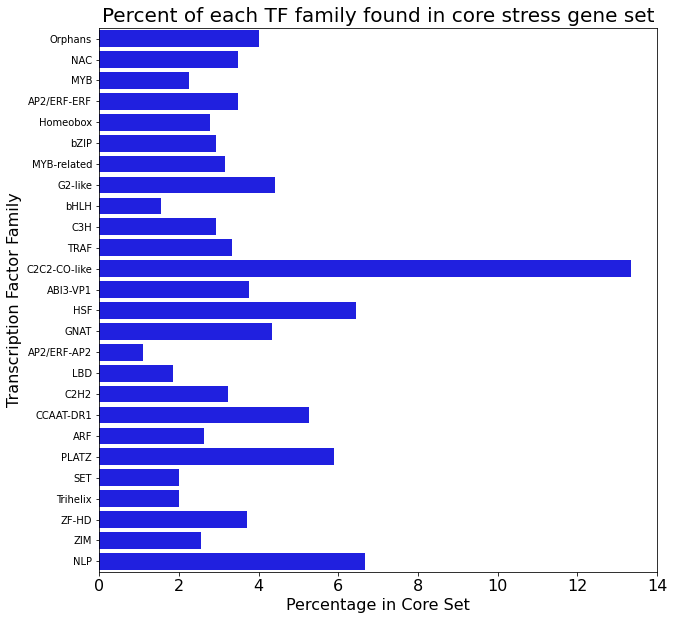

In [51]:
make_TF_barplot(list(psyn_cg_info["GeneID"].unique()),psyn_cg_info,"psyn_TF_families_percent_core_barplot.svg")

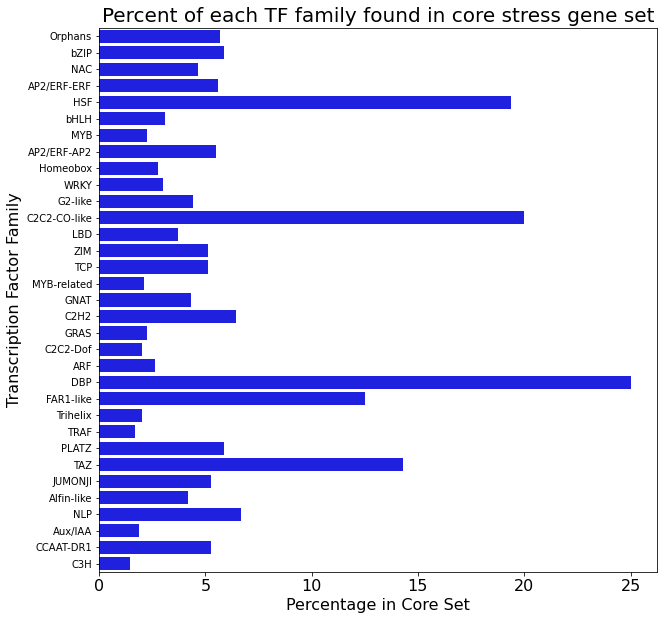

In [52]:
make_TF_barplot(list(all_cg_info["GeneID"].unique()),all_cg_info,"all_TF_families_percent_core_barplot.svg")